# Подключение библиотек

In [2]:
import torch
import torch.nn as nn
import torch
import torch.optim as optim
import torch.nn.functional as F

from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2
import glob
import random

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(1234)
if device =='cuda':
    torch.cuda.manual_seed_all(1234)

print(device)

cpu


#### Разделение набора данных на выборки

In [4]:
train_path=os.path.abspath('train_list')
test_path=os.path.abspath('test_list')
val_path=os.path.abspath('val_list')


df = pd.read_csv('annotation.csv', sep = ',', header=None)

df = df.drop(df.index[0])
df.drop(0, axis=1, inplace=True)
df.rename(columns={1: 'full_path', 2: 'img_class'}, inplace=True)
df.reset_index(inplace=True)
print(df)


if not os.path.isdir(train_path):
    os.mkdir(train_path)

if not os.path.isdir(test_path):
    os.mkdir(test_path)

if not os.path.isdir(val_path):
    os.mkdir(val_path)

def load_train(df: pd.core.frame.DataFrame, path: str, i: int) -> None:  
    '''
    Загружает  изображение из датафрейма по заданному пути 
    Parameters
        df(pd.core.frame.DataFrame): 
         датафрейм изображений 
        path(str): 
         путь до изображения
        i(int): 
         номер изображения 
    '''  
   
    
    image_path = os.path.abspath(os.path.join(*df.full_path[i].split("\\")))
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{df.img_class[i]}.{i}.jpg'), image)

def load_val(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
    ''' 
    Загружает  изображение из датафрейма по заданному пути 
    Parameters
        df(pd.core.frame.DataFrame): 
         датафрейм изображений 
        path(str): 
         путь до изображения
        i(int): 
         номер изображения 
    '''  
 
    image_path = os.path.join(*df.full_path[i].split("\\"))
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(*path.split("/"), f'{i}.jpg'), image)

def load_test(df: pd.core.frame.DataFrame, path: str, i: int) -> None:
    '''
    Загружает  изображение из датафрейма по заданному пути 
    Parameters
        df(pd.core.frame.DataFrame): 
         датафрейм изображений 
        path(str): 
         путь до изображения
        i(int): 
         номер изображения 
    '''
 
    image_path = os.path.join(*df.full_path[i].split("\\"))
    image = cv2.imread(image_path)
    cv2.imwrite(os.path.join(path, f'{i}.jpg'), image)


for i in range(800):
    load_train(df, train_path, i)
for i in range(1000,1800):
    load_train(df, train_path, i)
for i in range(800,900):
    load_test(df,test_path,i)
for i in range(1800,1900):
    load_test(df,test_path,i)
for i in range(900,1000):
    load_val(df,val_path,i)
for i in range(1900,1999):
    load_val(df,val_path,i)

train_list = glob.glob(os.path.join(train_path,'*.jpg'))
test_list = glob.glob(os.path.join(test_path, '*.jpg'))

train_list, val_list = train_test_split(train_list, test_size=0.1)

      index             full_path img_class
0         1  dataset\cat\0000.jpg       cat
1         2  dataset\cat\0001.jpg       cat
2         3  dataset\cat\0002.jpg       cat
3         4  dataset\cat\0003.jpg       cat
4         5  dataset\cat\0004.jpg       cat
...     ...                   ...       ...
1995   1996  dataset\dog\0995.jpg       dog
1996   1997  dataset\dog\0996.jpg       dog
1997   1998  dataset\dog\0997.jpg       dog
1998   1999  dataset\dog\0998.jpg       dog
1999   2000  dataset\dog\0999.jpg       dog

[2000 rows x 3 columns]


#### Проверка картинок

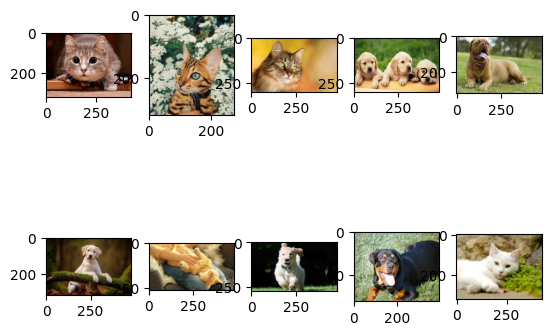

In [5]:
random_idx = np.random.randint(1,200,size=10)

fig = plt.figure()
i=1
for idx in random_idx:
    ax = fig.add_subplot(2,5,i)
    img = cv2.imread(train_list[idx])
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    i+=1

plt.show()

##### Увеличение изображений

In [6]:
train_transforms =  transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])

val_transforms = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ])


test_transforms = transforms.Compose([   
    transforms.Resize((224, 224)),
     transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor()
    ])

#### Загрузка наборов

In [7]:
from PIL import Image
class dataset(torch.utils.data.Dataset):
    def __init__(self,file_list,transform=None):
        self.file_list = file_list
        self.transform = transform
        
        
    
    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength
    
    
    def __getitem__(self,idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)
        
        label = img_path.split('\\')[-1].split('.')[0]
        if label == 'dog':
            label=1
        elif label == 'cat':
            label=0
            
        return img_transformed,label

In [8]:
train_data = dataset(train_list, transform=train_transforms)
test_data = dataset(test_list, transform=test_transforms)
val_data = dataset(val_list, transform=val_transforms)

#### Проверка данных

In [9]:
print(train_data[1])
print(val_data[0][1])

(tensor([[[1.0000, 1.0000, 1.0000,  ..., 0.6588, 0.6588, 0.6588],
         [1.0000, 1.0000, 1.0000,  ..., 0.6588, 0.6588, 0.6588],
         [1.0000, 1.0000, 1.0000,  ..., 0.6667, 0.6627, 0.6627],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 0.8235, 0.8235, 0.8235],
         [1.0000, 1.0000, 1.0000,  ..., 0.8235, 0.8235, 0.8235],
         [1.0000, 1.0000, 1.0000,  ..., 0.8235, 0.8235, 0.8235]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.5137, 0.5137, 0.5137],
         [1.0000, 1.0000, 1.0000,  ..., 0.5137, 0.5137, 0.5137],
         [1.0000, 1.0000, 1.0000,  ..., 0.5098, 0.5098, 0.5098],
         ...,
         [1.0000, 1.0000, 1.0000,  ..., 0.6196, 0.6196, 0.6196],
         [1.0000, 1.0000, 1.0000,  ..., 0.6196, 0.6196, 0.6196],
         [1.0000, 1.0000, 1.0000,  ..., 0.6196, 0.6196, 0.6196]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.4235, 0.4235, 0.4235],
         [1.0000, 1.0000, 1.0000,  ..., 0.4235, 0.4235, 0.4235],
         [1.0000, 1.0000, 1.0000,  ..., 0.4196, 0.4196, 0

# Обучение

In [10]:
lr = 0.001 
batch_size = 10 
epochs = 10 

In [11]:
train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

In [12]:
print(len(train_data), len(train_loader))

1440 144


In [13]:
print(len(val_data), len(val_loader))

160 16


#### Построение модели

#### модель сверточной нейросети для решения задачи классификации

In [14]:
class Cnn(nn.Module):
    def __init__(self):
        super(Cnn,self).__init__()

        self.layer1 = nn.Sequential(
            nn.Conv2d(3,16,kernel_size=3, padding=0,stride=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )

        self.layer2 = nn.Sequential(
            nn.Conv2d(16,32, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )


        self.layer3 = nn.Sequential(
            nn.Conv2d(32,64, kernel_size=3, padding=0, stride=2),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )


        self.fc1 = nn.Linear(3*3*64,10)
        self.dropout = nn.Dropout(0.5)
        self.fc2 = nn.Linear(10,2)
        self.relu = nn.ReLU()


    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = out.view(out.size(0),-1)
        out = self.relu(self.fc1(out))
        out = self.fc2(out)
        return out

In [15]:
model = Cnn().to(device)
model.train()

Cnn(
  (layer1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=576, out_features=10, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc2): Linear(in_features=10, out_features=2, bias=True)
  (re

In [16]:
print(len(train_data), len(train_loader))
print(len(val_data), len(val_loader))
train_data[0][0].shape

1440 144
160 16


torch.Size([3, 224, 224])

#### Цикл обучения

Epoch : 1, train accuracy : 0.5951390862464905, train loss : 0.6712244749069214
Epoch : 1, val_accuracy : 0.6000000238418579, val_loss : 0.6511232256889343
Epoch : 2, train accuracy : 0.6666669845581055, train loss : 0.6246700286865234
Epoch : 2, val_accuracy : 0.6312499642372131, val_loss : 0.6564671993255615
Epoch : 3, train accuracy : 0.6868056654930115, train loss : 0.6024279594421387
Epoch : 3, val_accuracy : 0.6624999046325684, val_loss : 0.5792379379272461
Epoch : 4, train accuracy : 0.693750262260437, train loss : 0.5855656862258911
Epoch : 4, val_accuracy : 0.6749999523162842, val_loss : 0.6070486903190613
Epoch : 5, train accuracy : 0.6847224235534668, train loss : 0.5835041999816895
Epoch : 5, val_accuracy : 0.668749988079071, val_loss : 0.605000376701355
Epoch : 6, train accuracy : 0.7284725308418274, train loss : 0.542972207069397
Epoch : 6, val_accuracy : 0.625, val_loss : 0.6758113503456116
Epoch : 7, train accuracy : 0.7118059396743774, train loss : 0.5485195517539978
E

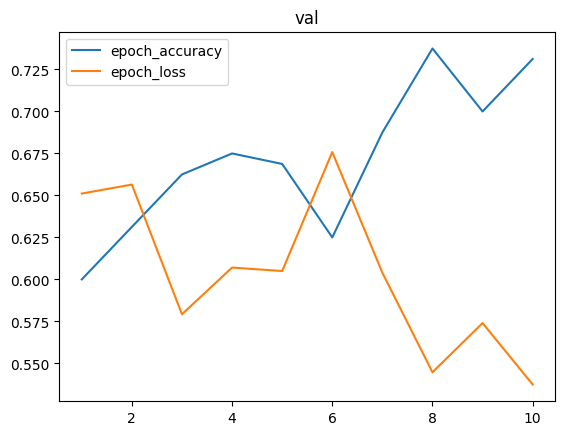

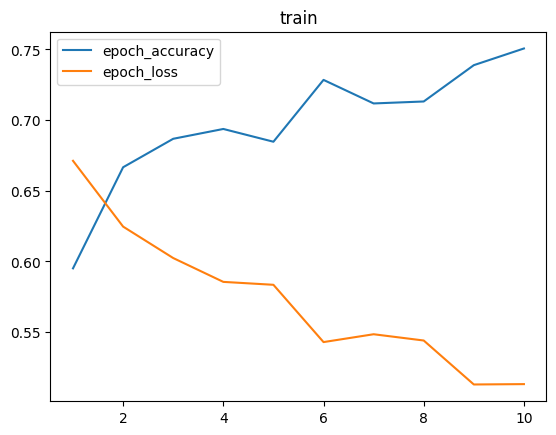

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=False)

def train(model, epochs):
  epoch_val_accuracy_list = []
  epoch_val_loss_list = []
  epoch_accuracy_list = []
  epoch_loss_list = []


  for epoch in range(epochs):
      epoch_loss = 0
      epoch_accuracy = 0

      for data, label in train_loader:
          data = data.to(device)
          label = label.to(device)

          output = model(data)
          loss = criterion(output, label)

          optimizer.zero_grad()
          loss.backward()
          optimizer.step()

          acc = ((output.argmax(dim=1) == label).float().mean())
          epoch_accuracy += acc/len(train_loader)
          epoch_loss += loss/len(train_loader)

      print('Epoch : {}, train accuracy : {}, train loss : {}'.format(epoch+1, epoch_accuracy,epoch_loss))
      epoch_accuracy_list.append(epoch_accuracy)
      epoch_loss_list.append(epoch_loss)
      with torch.no_grad():
          epoch_val_accuracy=0
          epoch_val_loss =0
          for data, label in val_loader:
              data = data.to(device)
              label = label.to(device)
              val_output = model(data)
              val_loss = criterion(val_output,label)


              acc = ((val_output.argmax(dim=1) == label).float().mean())
              epoch_val_accuracy += acc/ len(val_loader)
              epoch_val_loss += val_loss/ len(val_loader)

          print('Epoch : {}, val_accuracy : {}, val_loss : {}'.format(epoch+1, epoch_val_accuracy,epoch_val_loss))

      epoch_val_accuracy_list.append(epoch_val_accuracy)
      epoch_val_loss_list.append(epoch_val_loss)

  return(epoch_val_accuracy_list,epoch_val_loss_list,
  epoch_accuracy_list,
  epoch_loss_list)

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

def show_plot(accuracy_list, loss_list, text):
  x = list(range(1, len(accuracy_list)+ 1))
  plt.plot(x, accuracy_list, label = "epoch_accuracy")
  plt.plot(x, loss_list, label = "epoch_loss")
  plt.title(text)
  plt.legend()
  plt.show()

show_plot(epoch_val_accuracy_list, epoch_val_loss_list, "val")
show_plot(epoch_accuracy_list, [i.data for i in epoch_loss_list], "train")

Epoch : 1, train accuracy : 0.7729311585426331, train loss : 0.47541728615760803
Epoch : 1, val_accuracy : 0.7600000500679016, val_loss : 0.5199668407440186
Epoch : 2, train accuracy : 0.7834482192993164, train loss : 0.449616938829422
Epoch : 2, val_accuracy : 0.6850000023841858, val_loss : 0.5913762450218201
Epoch : 3, train accuracy : 0.7763793468475342, train loss : 0.44938772916793823
Epoch : 3, val_accuracy : 0.7699999809265137, val_loss : 0.491829514503479
Epoch : 4, train accuracy : 0.7862069010734558, train loss : 0.4529688358306885
Epoch : 4, val_accuracy : 0.7350000143051147, val_loss : 0.534725546836853
Epoch : 5, train accuracy : 0.7901723980903625, train loss : 0.44022542238235474
Epoch : 5, val_accuracy : 0.7799999713897705, val_loss : 0.526558518409729
Epoch : 6, train accuracy : 0.7943103313446045, train loss : 0.42795732617378235
Epoch : 6, val_accuracy : 0.75, val_loss : 0.5421147346496582
Epoch : 7, train accuracy : 0.79758620262146, train loss : 0.42405882477760315

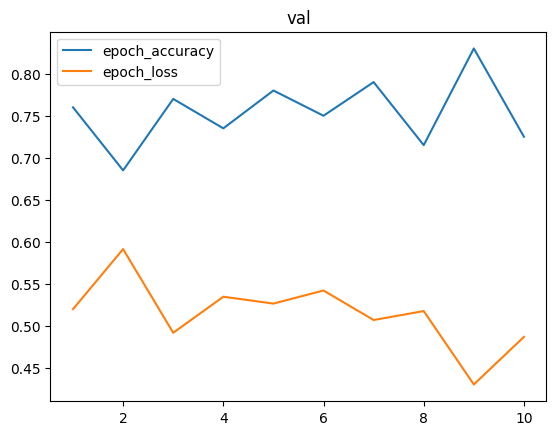

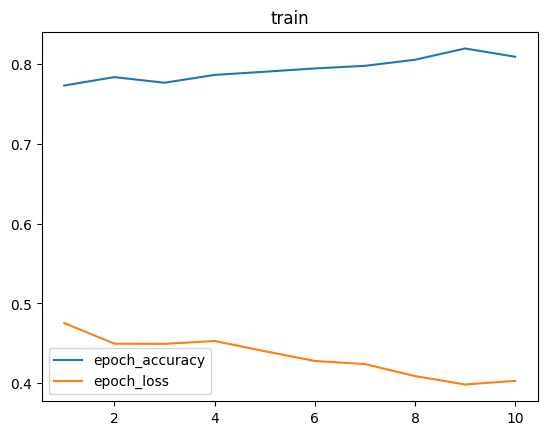

In [18]:
lr = 0.001 # learning_rate
batch_size = 50 # we will use mini-batch method

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(params = model.parameters(),lr=lr)
criterion = nn.CrossEntropyLoss()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot(epoch_val_accuracy_list, epoch_val_loss_list, "val")
show_plot(epoch_accuracy_list, [i.data for i in epoch_loss_list], "train")

Epoch : 1, train accuracy : 0.8174999952316284, train loss : 0.3977889120578766
Epoch : 1, val_accuracy : 0.7562500238418579, val_loss : 0.5287154316902161
Epoch : 2, train accuracy : 0.8024999499320984, train loss : 0.4153948724269867
Epoch : 2, val_accuracy : 0.7437499761581421, val_loss : 0.5049894452095032
Epoch : 3, train accuracy : 0.8356249928474426, train loss : 0.3719608783721924
Epoch : 3, val_accuracy : 0.768750011920929, val_loss : 0.501484751701355
Epoch : 4, train accuracy : 0.8362500667572021, train loss : 0.3795616328716278
Epoch : 4, val_accuracy : 0.84375, val_loss : 0.4429684281349182
Epoch : 5, train accuracy : 0.81312495470047, train loss : 0.3916700482368469
Epoch : 5, val_accuracy : 0.762499988079071, val_loss : 0.4586111009120941
Epoch : 6, train accuracy : 0.8181250095367432, train loss : 0.39892178773880005
Epoch : 6, val_accuracy : 0.7875000238418579, val_loss : 0.4663001596927643
Epoch : 7, train accuracy : 0.840624988079071, train loss : 0.36888083815574646

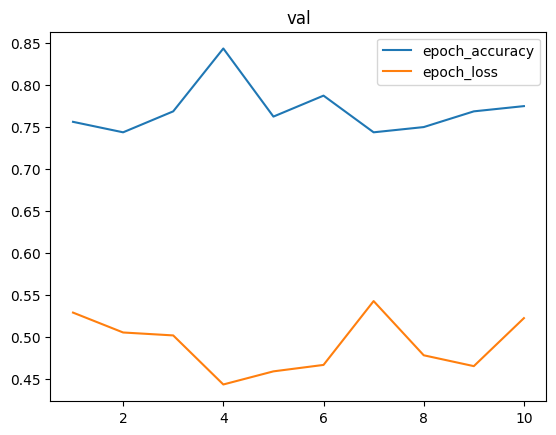

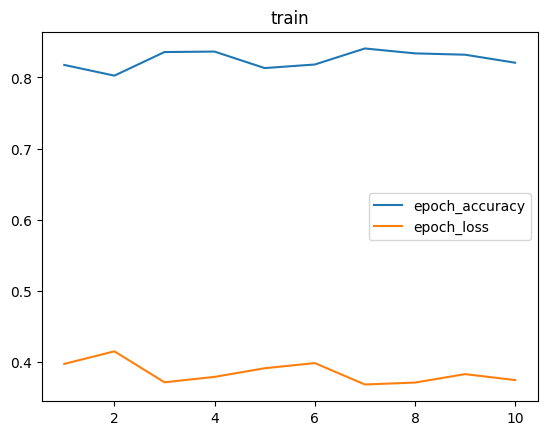

In [19]:
lr = 0.001 # learning_rate
batch_size = 200 # we will use mini-batch method

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(params = model.parameters(),lr=lr)
criterion = nn.CrossEntropyLoss()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot(epoch_val_accuracy_list, epoch_val_loss_list, "val")
show_plot(epoch_accuracy_list, [i.data for i in epoch_loss_list], "train")

Epoch : 1, train accuracy : 0.8168964982032776, train loss : 0.40660232305526733
Epoch : 1, val_accuracy : 0.7999999523162842, val_loss : 0.4034561514854431
Epoch : 2, train accuracy : 0.8303449153900146, train loss : 0.36733102798461914
Epoch : 2, val_accuracy : 0.7450000047683716, val_loss : 0.5102830529212952
Epoch : 3, train accuracy : 0.8246550559997559, train loss : 0.37925904989242554
Epoch : 3, val_accuracy : 0.8600000143051147, val_loss : 0.3699539005756378
Epoch : 4, train accuracy : 0.8082757592201233, train loss : 0.4001184105873108
Epoch : 4, val_accuracy : 0.8300000429153442, val_loss : 0.44474053382873535
Epoch : 5, train accuracy : 0.8277586102485657, train loss : 0.3706952631473541
Epoch : 5, val_accuracy : 0.7799999713897705, val_loss : 0.4558980464935303
Epoch : 6, train accuracy : 0.8400000333786011, train loss : 0.3748306334018707
Epoch : 6, val_accuracy : 0.75, val_loss : 0.4710124731063843
Epoch : 7, train accuracy : 0.8420689702033997, train loss : 0.34646162390

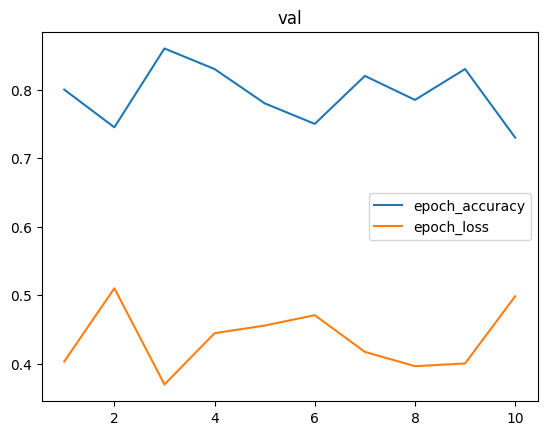

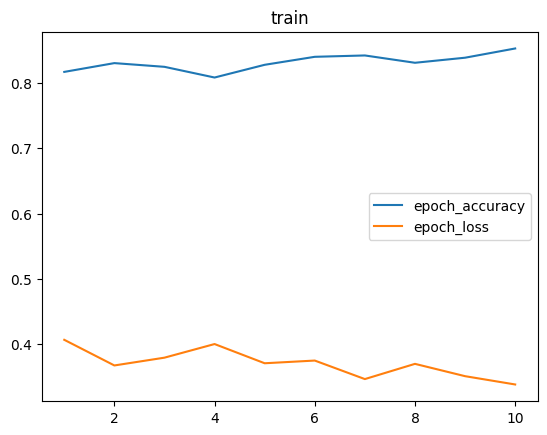

In [20]:
lr = 0.0005 # learning_rate
batch_size = 50 # we will use mini-batch method

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(params = model.parameters(),lr=lr)
criterion = nn.CrossEntropyLoss()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot(epoch_val_accuracy_list, epoch_val_loss_list, "val")
show_plot(epoch_accuracy_list, [i.data for i in epoch_loss_list], "train")

Epoch : 1, train accuracy : 0.8286667466163635, train loss : 0.36069586873054504
Epoch : 1, val_accuracy : 0.79666668176651, val_loss : 0.4458653926849365
Epoch : 2, train accuracy : 0.8373332619667053, train loss : 0.3621131181716919
Epoch : 2, val_accuracy : 0.78166663646698, val_loss : 0.46325504779815674
Epoch : 3, train accuracy : 0.8423333168029785, train loss : 0.3504807949066162
Epoch : 3, val_accuracy : 0.8116666674613953, val_loss : 0.43505704402923584
Epoch : 4, train accuracy : 0.8453333377838135, train loss : 0.3604935109615326
Epoch : 4, val_accuracy : 0.7799999713897705, val_loss : 0.45366591215133667
Epoch : 5, train accuracy : 0.844666600227356, train loss : 0.3560677170753479
Epoch : 5, val_accuracy : 0.7899999618530273, val_loss : 0.43246158957481384
Epoch : 6, train accuracy : 0.8450000286102295, train loss : 0.35004812479019165
Epoch : 6, val_accuracy : 0.8366666436195374, val_loss : 0.383294016122818
Epoch : 7, train accuracy : 0.8589999675750732, train loss : 0.3

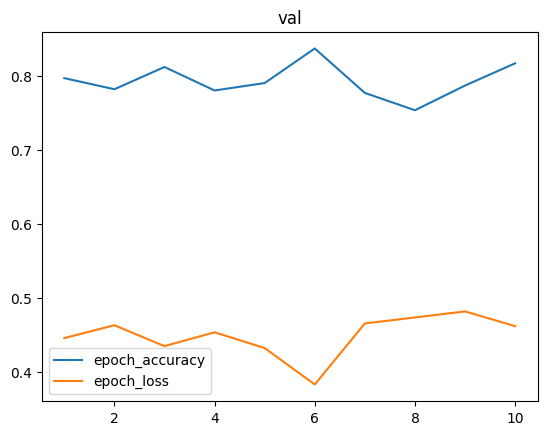

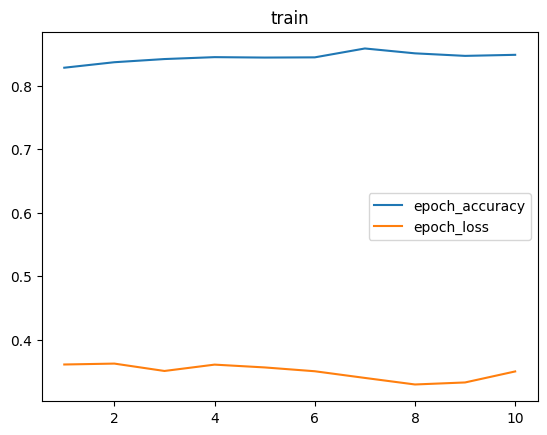

In [21]:
lr = 0.0005 # learning_rate
batch_size = 100 # we will use mini-batch method

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(params = model.parameters(),lr=lr)
criterion = nn.CrossEntropyLoss()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot(epoch_val_accuracy_list, epoch_val_loss_list, "val")
show_plot(epoch_accuracy_list, [i.data for i in epoch_loss_list], "train")

Epoch : 1, train accuracy : 0.8456249833106995, train loss : 0.34086930751800537
Epoch : 1, val_accuracy : 0.737500011920929, val_loss : 0.47104352712631226
Epoch : 2, train accuracy : 0.8449999690055847, train loss : 0.34034451842308044
Epoch : 2, val_accuracy : 0.7562500238418579, val_loss : 0.4553282856941223
Epoch : 3, train accuracy : 0.8518750071525574, train loss : 0.32548460364341736
Epoch : 3, val_accuracy : 0.800000011920929, val_loss : 0.4313174784183502
Epoch : 4, train accuracy : 0.8525000214576721, train loss : 0.31915903091430664
Epoch : 4, val_accuracy : 0.8187500238418579, val_loss : 0.43627840280532837
Epoch : 5, train accuracy : 0.8606249690055847, train loss : 0.3249126076698303
Epoch : 5, val_accuracy : 0.7875000238418579, val_loss : 0.45534467697143555
Epoch : 6, train accuracy : 0.8474999666213989, train loss : 0.344566285610199
Epoch : 6, val_accuracy : 0.8187500238418579, val_loss : 0.44880104064941406
Epoch : 7, train accuracy : 0.8625000715255737, train loss 

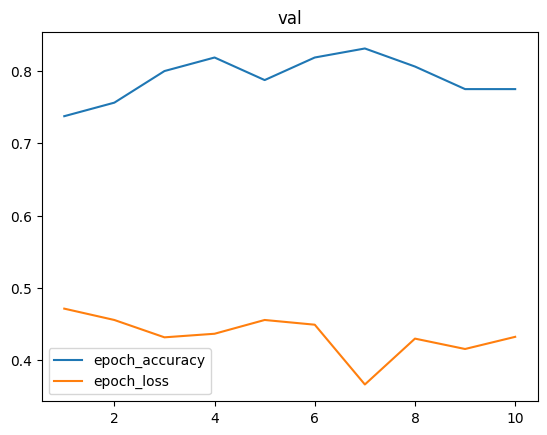

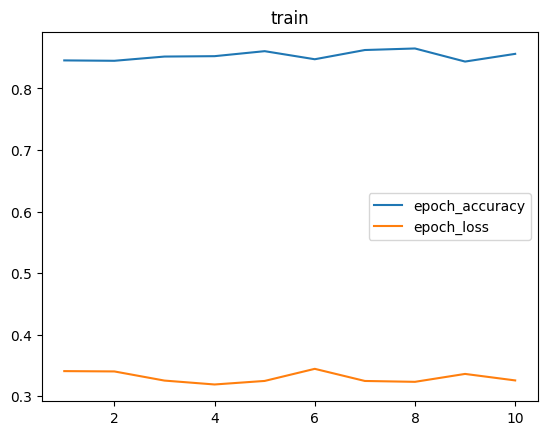

In [22]:
lr = 0.0005 # learning_rate
batch_size = 200 # we will use mini-batch method

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(params = model.parameters(),lr=lr)
criterion = nn.CrossEntropyLoss()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot(epoch_val_accuracy_list, epoch_val_loss_list, "val")
show_plot(epoch_accuracy_list, [i.data for i in epoch_loss_list], "train")

Epoch : 1, train accuracy : 0.7329311966896057, train loss : 0.5568745732307434
Epoch : 1, val_accuracy : 0.7250000238418579, val_loss : 0.5411408543586731
Epoch : 2, train accuracy : 0.7567241787910461, train loss : 0.4901750087738037
Epoch : 2, val_accuracy : 0.7900000810623169, val_loss : 0.47423771023750305
Epoch : 3, train accuracy : 0.7789656519889832, train loss : 0.45289215445518494
Epoch : 3, val_accuracy : 0.7549999952316284, val_loss : 0.46939003467559814
Epoch : 4, train accuracy : 0.7727586030960083, train loss : 0.4733828604221344
Epoch : 4, val_accuracy : 0.6549999713897705, val_loss : 0.6783072352409363
Epoch : 5, train accuracy : 0.7901723980903625, train loss : 0.46160268783569336
Epoch : 5, val_accuracy : 0.824999988079071, val_loss : 0.3806854784488678
Epoch : 6, train accuracy : 0.7886207103729248, train loss : 0.44712990522384644
Epoch : 6, val_accuracy : 0.7200000286102295, val_loss : 0.5038410425186157
Epoch : 7, train accuracy : 0.7903448343276978, train loss :

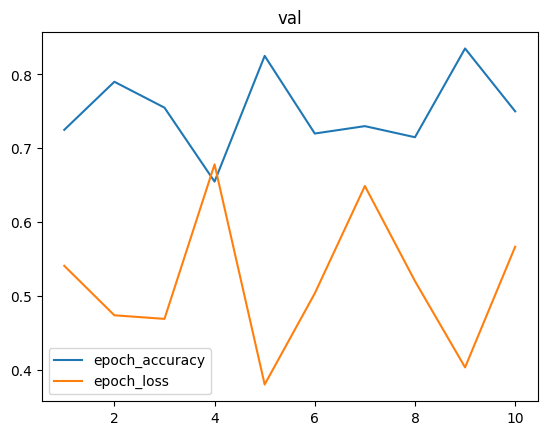

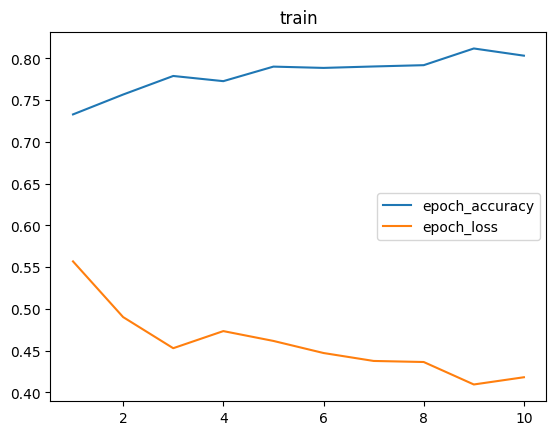

In [23]:
lr = 0.005 # learning_rate
batch_size = 50 # we will use mini-batch method

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(params = model.parameters(),lr=lr)
criterion = nn.CrossEntropyLoss()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot(epoch_val_accuracy_list, epoch_val_loss_list, "val")
show_plot(epoch_accuracy_list, [i.data for i in epoch_loss_list], "train")

Epoch : 1, train accuracy : 0.7923333644866943, train loss : 0.45821723341941833
Epoch : 1, val_accuracy : 0.7116667032241821, val_loss : 0.5265846252441406
Epoch : 2, train accuracy : 0.8059999346733093, train loss : 0.4096269905567169
Epoch : 2, val_accuracy : 0.78166663646698, val_loss : 0.5080478191375732
Epoch : 3, train accuracy : 0.8146666288375854, train loss : 0.4119766056537628
Epoch : 3, val_accuracy : 0.7683333158493042, val_loss : 0.4654879570007324
Epoch : 4, train accuracy : 0.8146666884422302, train loss : 0.3991473317146301
Epoch : 4, val_accuracy : 0.7566666603088379, val_loss : 0.5252840518951416
Epoch : 5, train accuracy : 0.8169999718666077, train loss : 0.39624878764152527
Epoch : 5, val_accuracy : 0.8116666674613953, val_loss : 0.4371796250343323
Epoch : 6, train accuracy : 0.8226667046546936, train loss : 0.3790402114391327
Epoch : 6, val_accuracy : 0.8250000476837158, val_loss : 0.41424188017845154
Epoch : 7, train accuracy : 0.8339999914169312, train loss : 0.

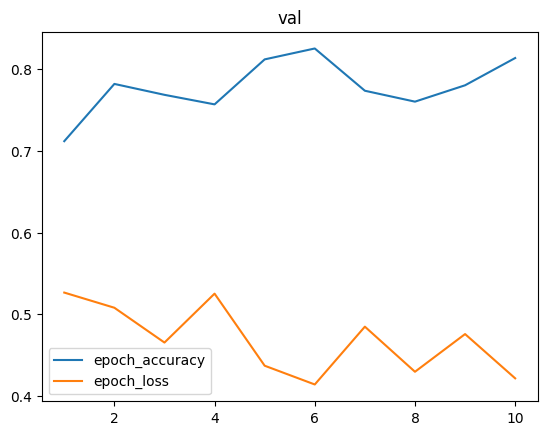

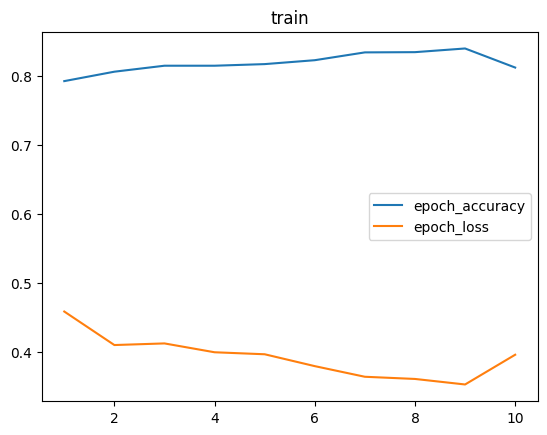

In [24]:
lr = 0.005 # learning_rate
batch_size = 100 # we will use mini-batch method

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(params = model.parameters(),lr=lr)
criterion = nn.CrossEntropyLoss()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot(epoch_val_accuracy_list, epoch_val_loss_list, "val")
show_plot(epoch_accuracy_list, [i.data for i in epoch_loss_list], "train")

Epoch : 1, train accuracy : 0.8443750143051147, train loss : 0.36554431915283203
Epoch : 1, val_accuracy : 0.800000011920929, val_loss : 0.47594133019447327
Epoch : 2, train accuracy : 0.8418750166893005, train loss : 0.35888412594795227
Epoch : 2, val_accuracy : 0.768750011920929, val_loss : 0.3841764032840729
Epoch : 3, train accuracy : 0.8287500143051147, train loss : 0.3762052655220032
Epoch : 3, val_accuracy : 0.793749988079071, val_loss : 0.4585880637168884
Epoch : 4, train accuracy : 0.82874995470047, train loss : 0.3681236505508423
Epoch : 4, val_accuracy : 0.7562500238418579, val_loss : 0.466522216796875
Epoch : 5, train accuracy : 0.8387500047683716, train loss : 0.35032567381858826
Epoch : 5, val_accuracy : 0.7875000238418579, val_loss : 0.46516284346580505
Epoch : 6, train accuracy : 0.8481249809265137, train loss : 0.3354880213737488
Epoch : 6, val_accuracy : 0.800000011920929, val_loss : 0.4437296986579895
Epoch : 7, train accuracy : 0.8343750238418579, train loss : 0.375

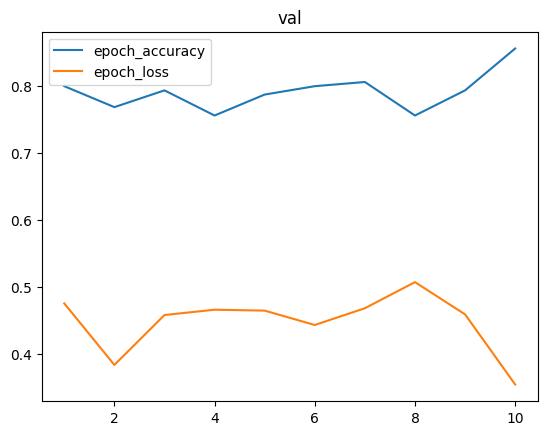

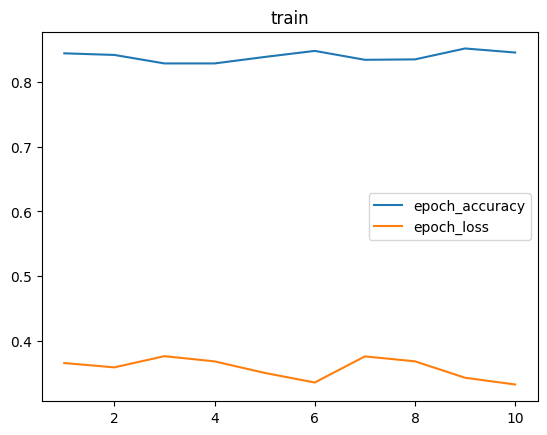

In [25]:
lr = 0.005 # learning_rate
batch_size = 200 # we will use mini-batch method

train_loader = torch.utils.data.DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset = val_data, batch_size=batch_size, shuffle=True)

optimizer = optim.Adam(params = model.parameters(),lr=lr)
criterion = nn.CrossEntropyLoss()

epoch_val_accuracy_list,epoch_val_loss_list,epoch_accuracy_list,epoch_loss_list = train(model, epochs)

show_plot(epoch_val_accuracy_list, epoch_val_loss_list, "val")
show_plot(epoch_accuracy_list, [i.data for i in epoch_loss_list], "train")

#### Работа с моделью

In [26]:
dog_probs = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        preds = model(images)
        preds_list = F.softmax(preds, dim=1)[:, 1].tolist()
        dog_probs += list(zip(labels, preds_list))

dog_probs.sort(key = lambda x : int(x[0]))     
idx = list(map(lambda x: x[0],dog_probs))
prob = list(map(lambda x: x[1],dog_probs))

submission = pd.DataFrame({'id':idx,'label':prob})

submission

,id,label
0,800,0.007313
1,801,0.061248
2,802,0.177260
3,803,0.040498
4,804,0.122358
...,...,...
195,1895,0.190452
196,1896,0.458834
197,1897,0.189104
198,1898,0.903465


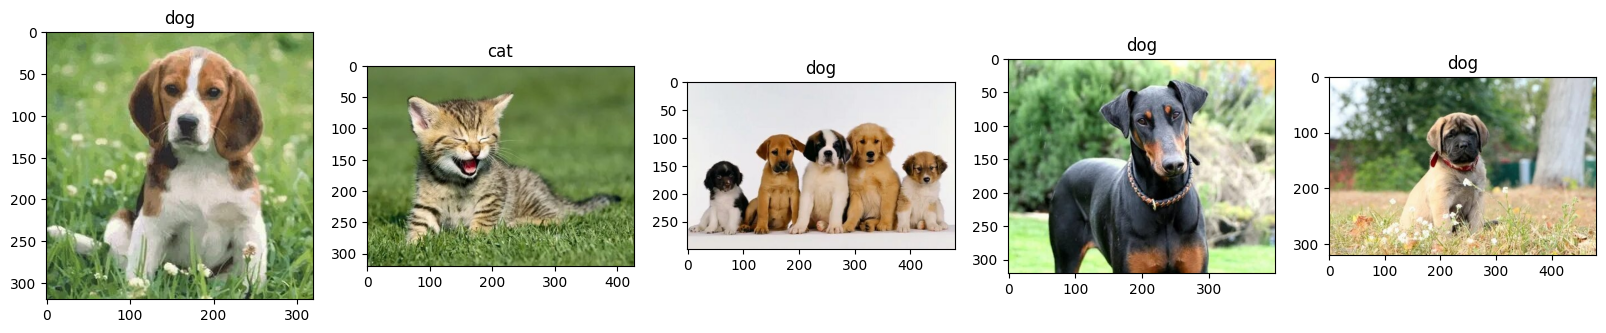

In [44]:
class_ = {0: 'cat', 1: 'dog'}

fig, axes = plt.subplots(1, 5, figsize=(20, 12), facecolor='w')

for ax in axes.ravel():
    
    i = random.choice(submission['id'].values)
    
    label = submission.loc[submission['id'] == i, 'label'].values[0]
    if label > 0.5:
        label = 1
    else:
        label = 0
        
    img_path = os.path.join(test_path, f'{i}.jpg')
    img = Image.open(img_path)
    
    ax.set_title(class_[label])
    ax.imshow(img)

#### Сохранение модели и работа на тестовых данных

In [28]:
torch.save(model.state_dict(), os.path.join("C:/Users/Professional/Desktop/labpython", "weight.pt"))

In [29]:
mymodel = Cnn()
mymodel.load_state_dict(torch.load(os.path.join("C:/Users/Professional/Desktop/labpython", "weight.pt")))

<All keys matched successfully>

tensor([[ 1.2647, -0.8016]], grad_fn=<AddmmBackward0>)

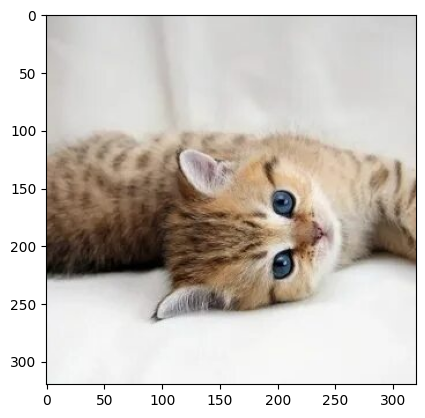

In [45]:
import random
from PIL import Image

list_files = os.listdir(test_path)
file = list_files[random.randint(0,len(list_files)-1)]

img_path = os.path.join(test_path, file)

img = Image.open(img_path)
img_transformed = test_transforms(img).unsqueeze(dim=0)

output = mymodel(img_transformed)

img = Image.open(img_path)
plt.imshow(img)

output